In [10]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [6]:
%%capture output
!unzip Model.zip

In [11]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series, plot_joint_angle_from_sto_file as pja, plot_act_length_from_sto_file as pal
from neural_simulations import run_neural_simulations, run_flexor_extensor_neuron_simulation
from activation import decode_spikes_to_activation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


--- Iteration 1 of 2 ---
--- Iteration 2 of 2 ---
Saved: results/Spikes_aff_0_eff_0_freq_0. Hz.json


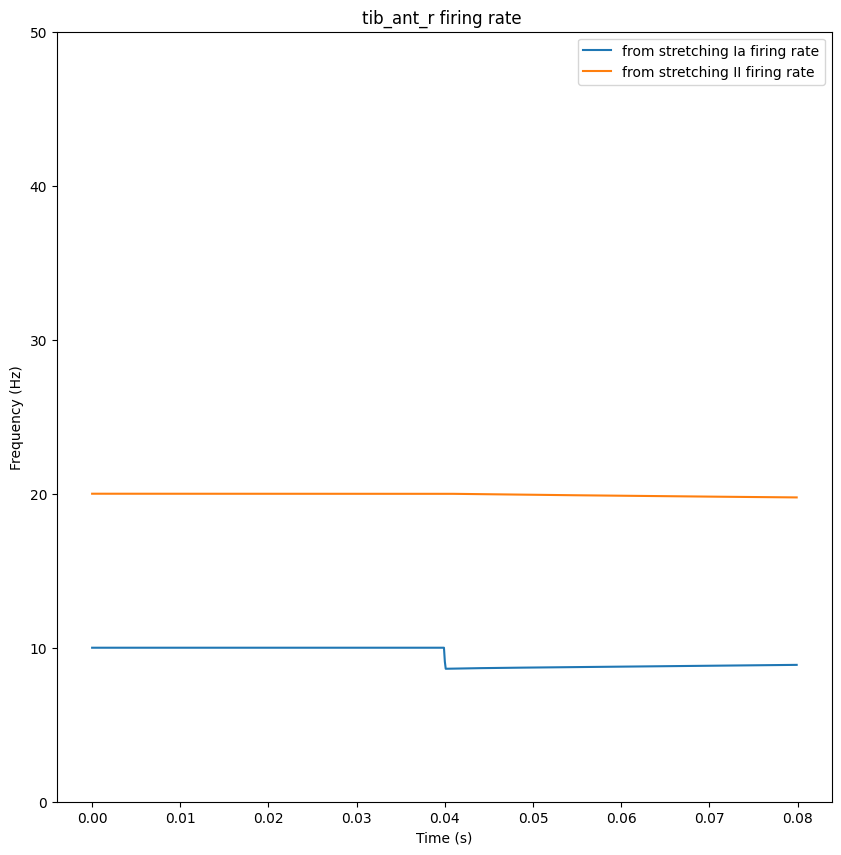

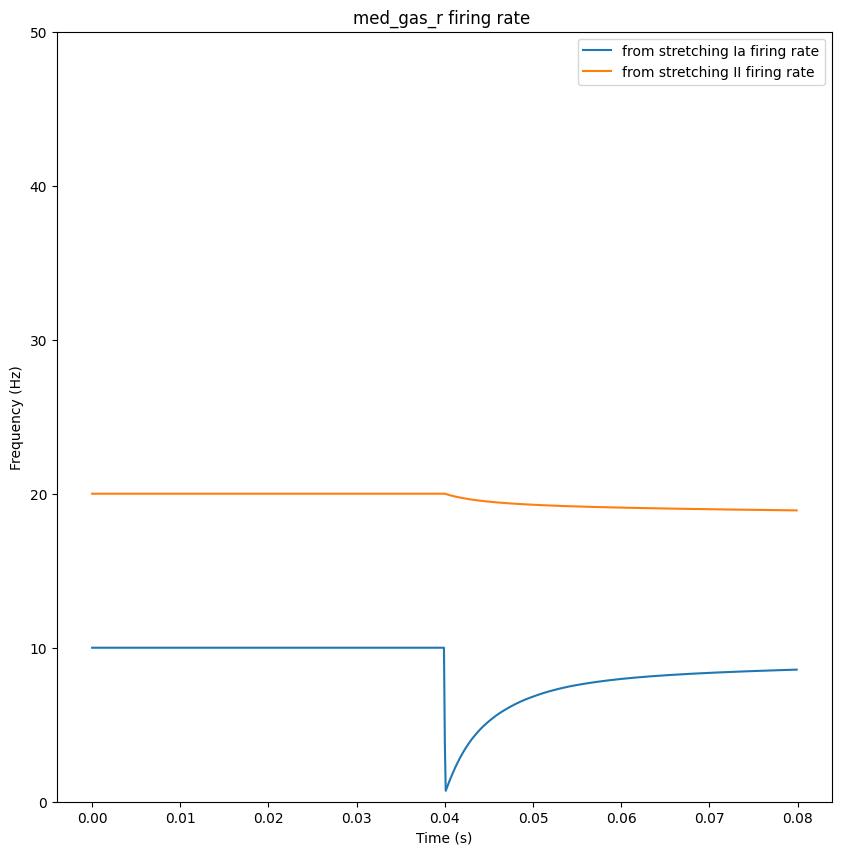

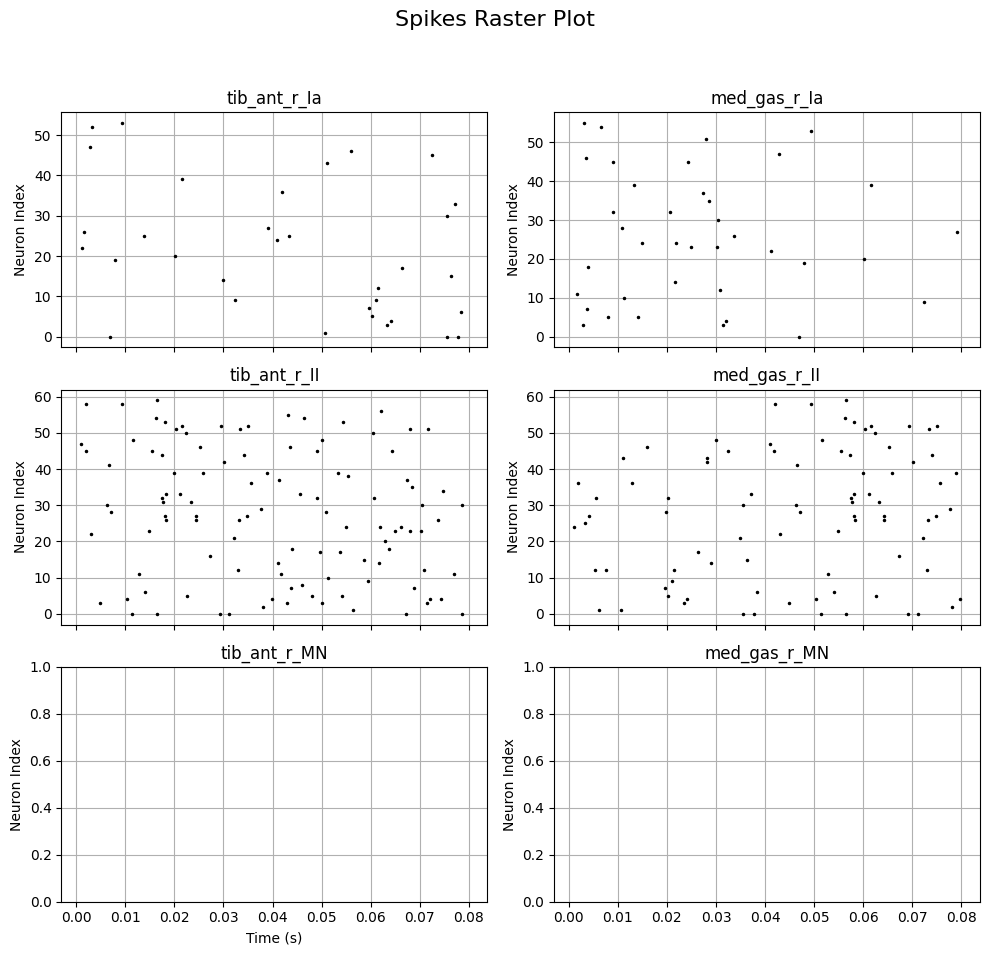

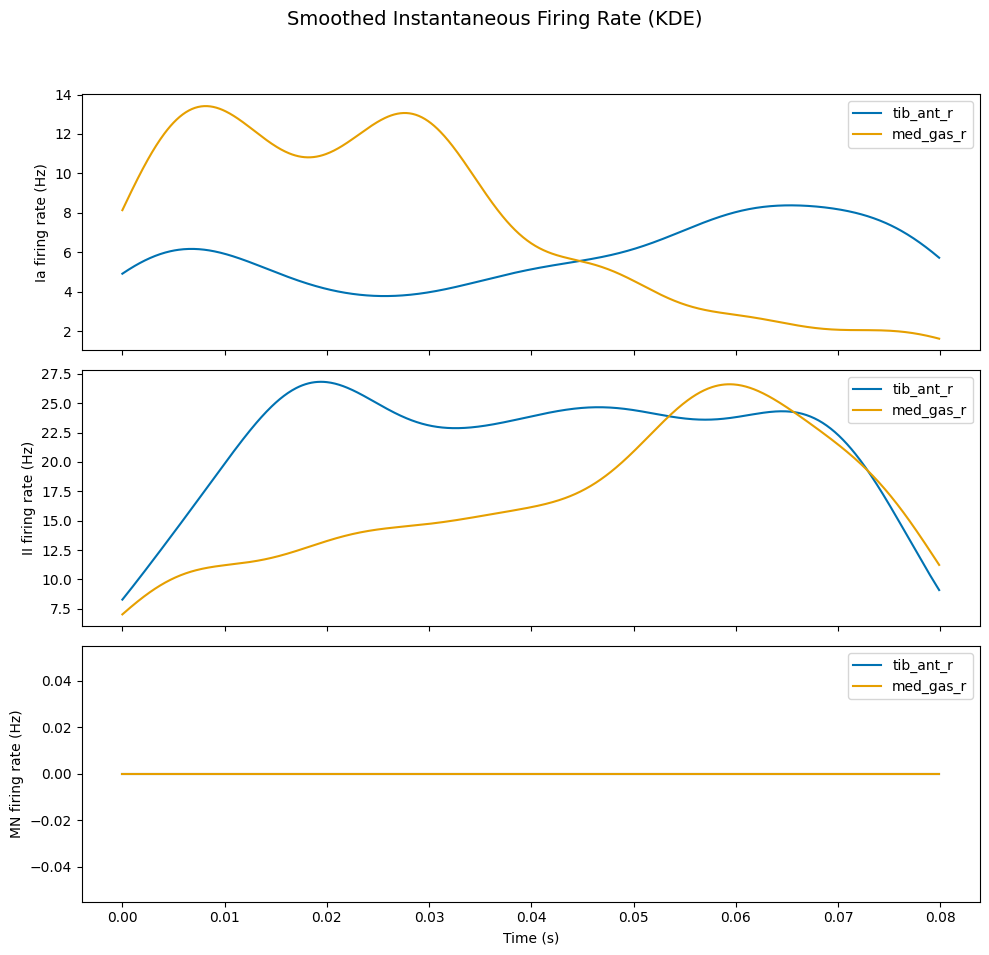

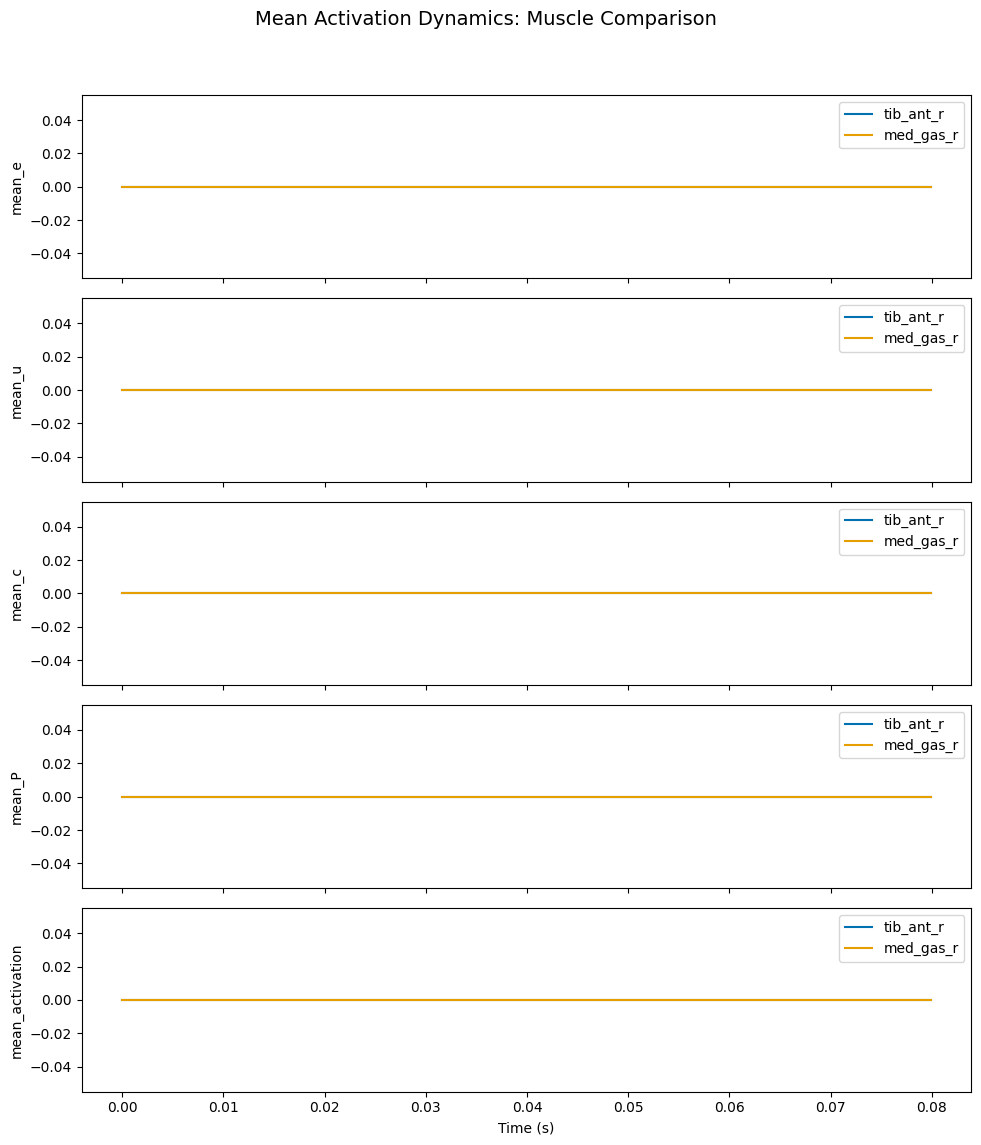

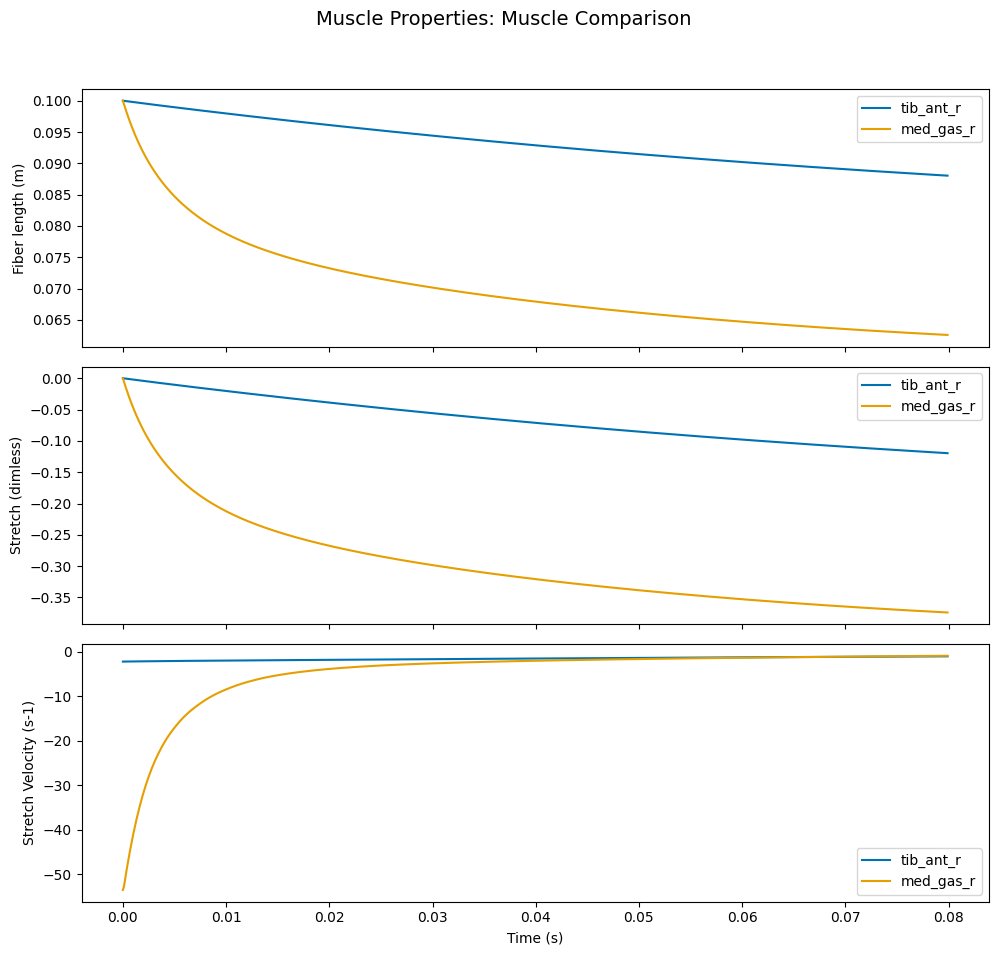

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
results/All_opensim_aff_0_eff_0_freq_0. Hz.sto file is saved




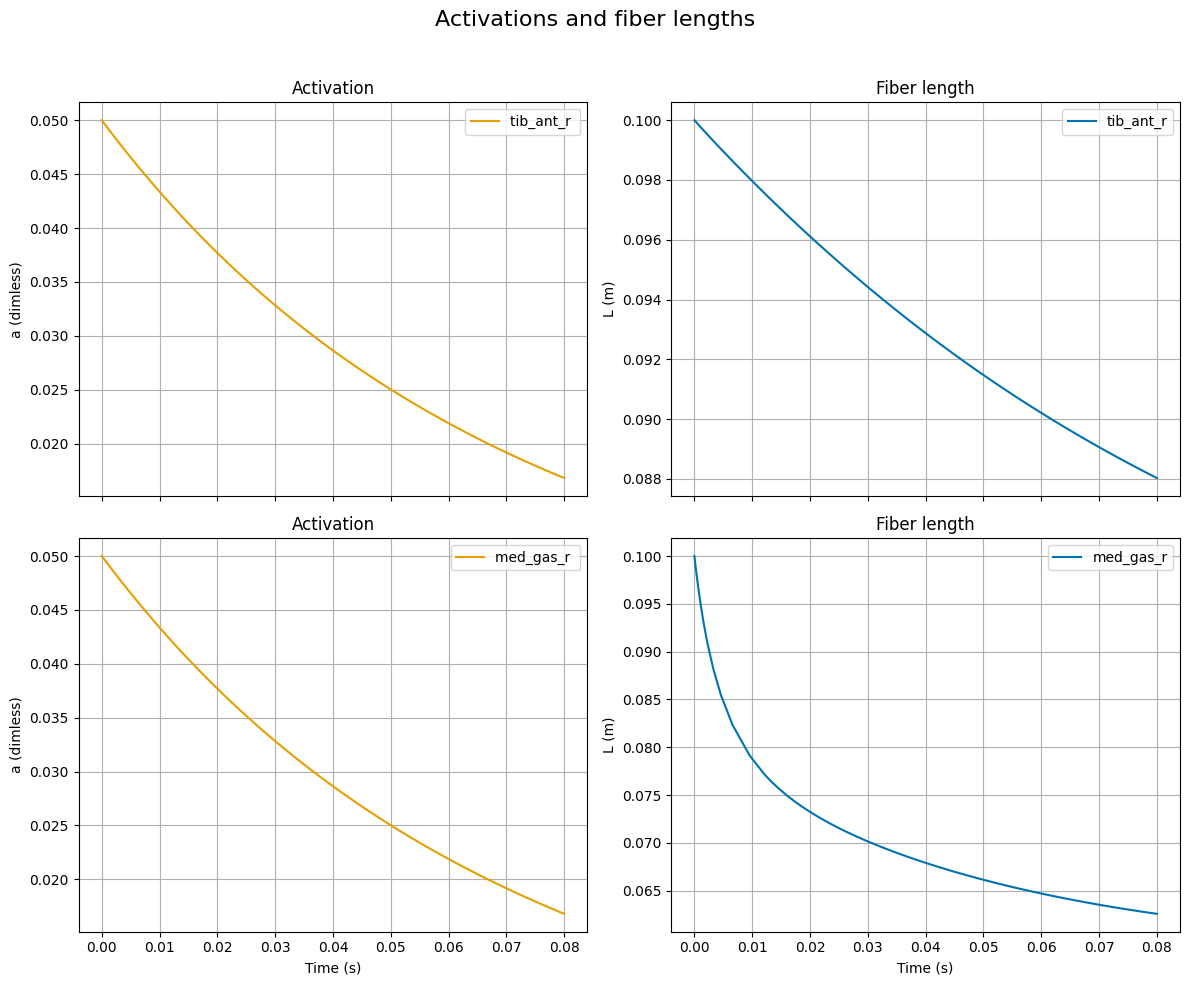

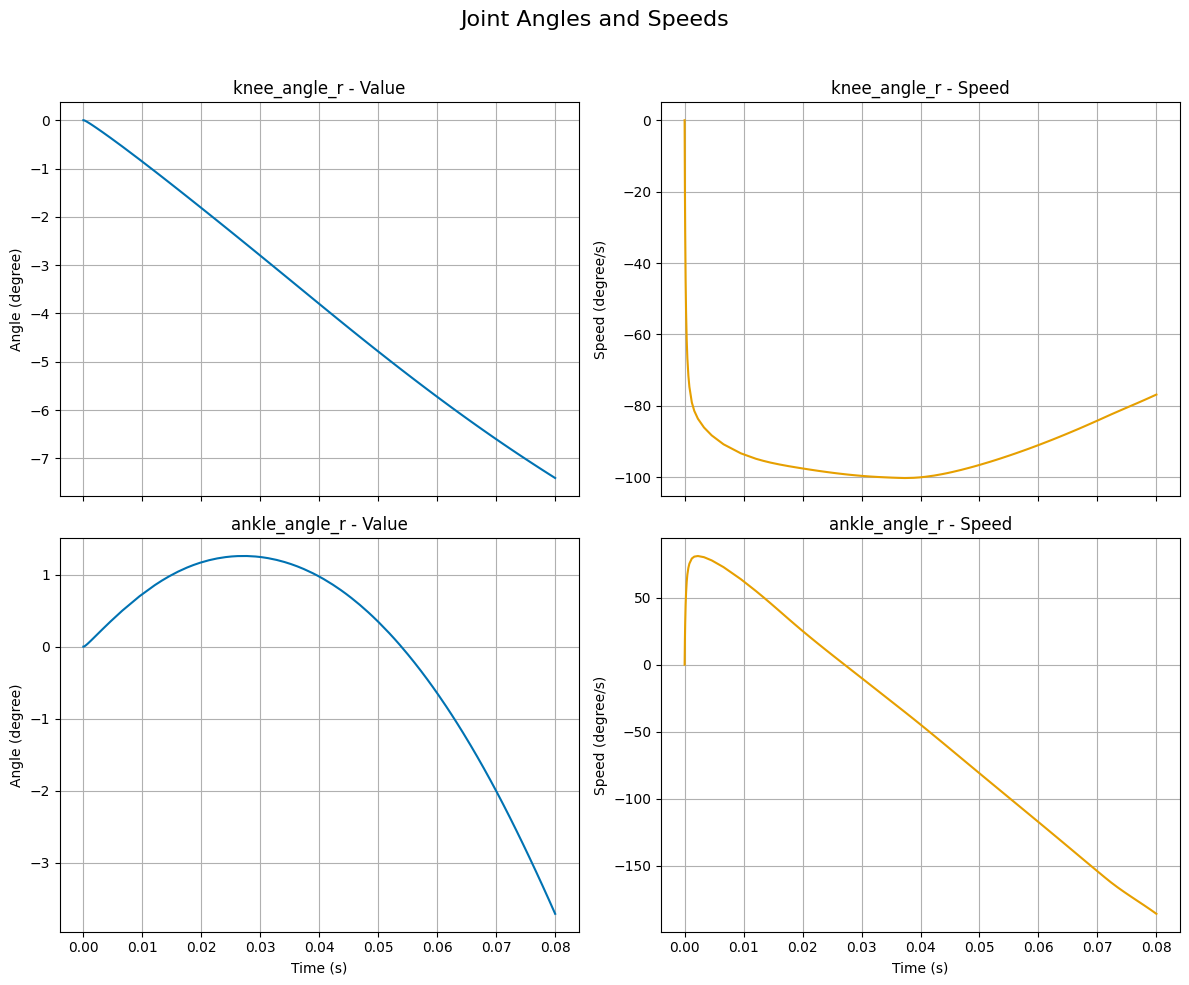

In [42]:
"""
Neuromuscular Simulation Pipeline

This script runs a neuromuscular simulation that integrates:
1. Neural spike generation
2. Spike-to-activation decoding
3. Muscle length/velocity simulation via OpenSim

The pipeline iteratively simulates neural activity and muscle dynamics,
passing information between these components to create a closed-loop system.
"""

# =============================================================================
# Configuration Parameters
# =============================================================================

# Time parameters
REACTION_TIME = 40 * ms  # Duration of each simulation iteration
NUM_ITERATIONS = 2      # Number of simulation iterations
TIME_STEP = 0.1 * ms     # Simulation time step

# Neural population parameters
NEURON_COUNTS = {
    "Ia": 60,       # Type Ia afferent neurons
    "II": 60,       # Type II afferent neurons
    "inh": 196,     # Inhibitory interneurons
    "exc": 196,     # Excitatory interneurons
    "motor": 169    # Motor neurons
}

# Electrical stimulation parameters
EES_PARAMS = {
    'ees_freq': 0 * hertz,      # Frequency of epidural electrical stimulation
    'aff_recruited': 0,         # Percentage of afferent fibers recruited
    'eff_recruited': 0       # Percentage of efferent fibers recruited
}

# Neuron biophysical parameters
BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'scaling_weight': 100,
    'Eleaky':-70*mV,
    'gL':0.1*mS,
    'Cm':1*uF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_exc':0.5*ms,
    'tau_inh_1':1.5*ms,
    'tau_inh_2':2*ms,
    'threshold_v':-60*mV
}

# Muscle configuration
MUSCLE_NAMES_STR = "tib_ant_r,med_gas_r"  # Comma-separated muscle names
MUSCLE_NAMES = MUSCLE_NAMES_STR.split(",")
NUM_MUSCLES = len(MUSCLE_NAMES)

# Validate muscle count
if NUM_MUSCLES > 2:
    raise ValueError("This pipeline supports only 1 or 2 muscles!")

# =============================================================================
# Initialization
# =============================================================================

# Initialize arrays to store muscle stretch and velocity
stretch = np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP)))
velocity = np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP)))
stretch0=stretch.copy()

initial_potentials=None
# Initialize decoder states for each motor neuron in each muscle
initial_decoder_states = [
    {i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0': [0.0], 'a0': [0.0]}
     for i in range(NEURON_COUNTS["motor"])}
    for _ in range(NUM_MUSCLES)
]

# Containers for simulation data
muscle_data = [[] for _ in range(NUM_MUSCLES)]
resting_lengths = [None] * NUM_MUSCLES


# Structure to store spike data for all muscles and neuron types
spike_data = {
    muscle_name: {
        "Ia": defaultdict(list),
        "II": defaultdict(list),
        "MN": defaultdict(list)
    } for muscle_name in MUSCLE_NAMES
}

# Create results directory
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Use temporary file for state management across iterations
state_file = None

# =============================================================================
# Main Simulation Loop
# =============================================================================

for iteration in range(NUM_ITERATIONS):
    print(f"--- Iteration {iteration+1} of {NUM_ITERATIONS} ---")

    # Run neural simulation based on muscle count
    if NUM_MUSCLES == 1:
        all_spikes, final_potentials = run_neural_simulations(
            stretch, velocity, NEURON_COUNTS, TIME_STEP, REACTION_TIME,initial_potentials
            **EES_PARAMS, **BIOPHYSICAL_PARAMS
        )
    else:  # NUM_MUSCLES == 2
        all_spikes,  final_potentials = run_flexor_extensor_neuron_simulation(
            stretch, velocity, NEURON_COUNTS, TIME_STEP, REACTION_TIME, initial_potentials,
            **EES_PARAMS, **BIOPHYSICAL_PARAMS
        )
    initial_potential=final_potentials
    # Store spike times for visualization
    for muscle_idx, muscle_name in enumerate(MUSCLE_NAMES):
        muscle_spikes = all_spikes[muscle_idx]
        for fiber_type, fiber_spikes in muscle_spikes.items():
            for neuron_id, spikes in fiber_spikes.items():
                # Adjust spike times by iteration offset
                adjusted_spikes = spikes/second + iteration * REACTION_TIME/second
                spike_data[muscle_name][fiber_type][neuron_id].extend(adjusted_spikes)

    # Initialize arrays for mean values of all neurons per muscle
    mean_e, mean_u, mean_c, mean_P, mean_activation = [
        np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP))) for _ in range(5)
    ]

    # Process motor neuron spikes to get muscle activations
    for muscle_idx, muscle_spikes in enumerate(all_spikes):
        # Only process if we have motor neuron spikes
        if len(muscle_spikes["MN"]) > 0:
            # Convert spike times to seconds
            mn_spikes_sec = [value/second for _, value in muscle_spikes["MN"].items()]

            # Decode spikes to muscle activations
            e, u, c, P, activations, final_values = decode_spikes_to_activation(
                mn_spikes_sec,
                TIME_STEP/second,
                REACTION_TIME/second,
                initial_decoder_states[muscle_idx]
            )

            # Store mean values across all neurons
            mean_e[muscle_idx] = np.mean(e, axis=0)
            mean_u[muscle_idx] = np.mean(u, axis=0)
            mean_c[muscle_idx] = np.mean(c, axis=0)
            mean_P[muscle_idx] = np.mean(P, axis=0)
            mean_activation[muscle_idx] = np.mean(activations, axis=0)

            # Save final state for next iteration
            initial_decoder_states[muscle_idx] = final_values

    # Run OpenSim muscle simulation using the computed activations
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_file, \
         tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_file, \
         tempfile.NamedTemporaryFile(suffix='.json', delete=False) as new_state_file:

        input_path = input_file.name
        output_path = output_file.name
        new_state_path = new_state_file.name

        # Save activations to temporary file
        np.save(input_path, mean_activation)

        # Build command for OpenSim muscle simulation
        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(TIME_STEP/second),
            '--T', str(REACTION_TIME/second),
            '--muscles', MUSCLE_NAMES_STR,
            '--activation', input_path,
            '--output_stretch', output_path,
            '--output_final_state', new_state_path
        ]

        # Add initial state parameter if not the first iteration
        if iteration > 0:
            cmd += ['--initial_state', state_file]

        # Run OpenSim simulation
        process = subprocess.run(cmd, capture_output=True, text=True)

        #if process.stdout.strip():
        #    print("STDOUT:\n", process.stdout)

        # Process OpenSim results
        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            # Load muscle lengths from simulation
            fiber_lengths = np.load(output_path)
            # Remove the last value as it will be included in the next iteration
            fiber_lengths = fiber_lengths[:, :-1]

            # Process each muscle's data
            for muscle_idx in range(NUM_MUSCLES):
                # Set resting length on first iteration
                if iteration == 0:
                    resting_lengths[muscle_idx] = fiber_lengths[muscle_idx, 0]

                # Calculate stretch and velocity for next iteration
                stretch[muscle_idx] = fiber_lengths[muscle_idx] / resting_lengths[muscle_idx] - 1
                time_points = np.arange(0, REACTION_TIME/second, TIME_STEP/second)
                velocity[muscle_idx] = np.gradient(stretch[muscle_idx], time_points)

                # Create batch data for current iteration
                batch_data = {
                    'mean_e': mean_e[muscle_idx],
                    'mean_u': mean_u[muscle_idx],
                    'mean_c': mean_c[muscle_idx],
                    'mean_P': mean_P[muscle_idx],
                    'mean_activation': mean_activation[muscle_idx],
                    'fiber_length': fiber_lengths[muscle_idx],
                    'stretch': stretch[muscle_idx],
                    'velocity': velocity[muscle_idx]
                }

                # Store batch data for this muscle
                muscle_data[muscle_idx].append(pd.DataFrame(batch_data))
        else:
            error_msg = f'Error in iteration {iteration+1}. STDERR: {process.stderr}'
            raise RuntimeError(error_msg)

        # Clean up the old state file if it exists
        if state_file is not None:
            os.unlink(state_file)

        # Update state file for next iteration
        state_file = new_state_path

        # Clean up other temporary files
        os.unlink(input_path)
        os.unlink(output_path)

# =============================================================================
# Save Results
# =============================================================================

# Combine muscle-specific data

muscle_dataframes = []

# Process and save data for each muscle
for muscle_idx, muscle_name in enumerate(MUSCLE_NAMES):

    # Combine all iteration data for this muscle
    combined_df = pd.concat(muscle_data[muscle_idx], ignore_index=True)

    # Add time column as first column
    combined_df['Time'] = np.arange(len(combined_df)) * (TIME_STEP/second)
    combined_df = combined_df[['Time'] + [col for col in combined_df.columns if col != 'Time']]

    # Store dataframe for plotting
    muscle_dataframes.append(combined_df)


# Save spike data
spikes_path = os.path.join(
    RESULTS_DIR,
    f'Spikes_aff_{EES_PARAMS["aff_recruited"]}_'
    f'eff_{EES_PARAMS["eff_recruited"]}_freq_{EES_PARAMS["ees_freq"]}.json'
)
with open(spikes_path, "w") as f:
    json.dump(spike_data, f, indent=4)
print(f"Saved: {spikes_path}")


# =============================================================================
# Generate Plots
# =============================================================================

# Generate time series plots
plot_times_series(stretch0,spike_data, muscle_dataframes, MUSCLE_NAMES, RESULTS_DIR, **EES_PARAMS)

# =============================================================================
# Run Complete Muscle Simulation
# =============================================================================

# Create full simulation STO file for visualization
complete_sto_name = f'All_opensim_' \
                   f'aff_{EES_PARAMS["aff_recruited"]}_' \
                   f'eff_{EES_PARAMS["eff_recruited"]}_' \
                   f'freq_{EES_PARAMS["ees_freq"]}.sto'
complete_sto_path = os.path.join(RESULTS_DIR, complete_sto_name)

# Create temporary file for activation data
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_file:
    input_path = input_file.name

    # Save muscle activations without time column
    activations_array = np.zeros((NUM_MUSCLES, len((muscle_dataframes[0]))))
    for i in range(NUM_MUSCLES):
        activations_array[i]=muscle_dataframes[i]['mean_activation'].T.to_numpy()

    np.save(input_path, activations_array)


    # Build command for full muscle simulation
    cmd = [
        'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
        '--dt', str(TIME_STEP/second),
        '--T', str(REACTION_TIME/second * NUM_ITERATIONS),
        '--muscle', MUSCLE_NAMES_STR,
        '--activation', input_path,
        '--output_all', complete_sto_path
    ]

    # Run OpenSim simulation for complete trajectory
    process = subprocess.run(cmd, capture_output=True, text=True)

    if process.stdout.strip():
        print("STDOUT:\n", process.stdout)
    if process.stderr.strip():
        print(f"STDERR: {process.stderr}")

    # Clean up temporary file
    os.unlink(input_path)

# =============================================================================
# Joint Analysis
# =============================================================================

# Define joint angles of interest
JOINT_COLUMNS = [
    #"hip_flexion_r",
    #"hip_adduction_r",
    #"hip_rotation_r",
    "knee_angle_r",
    "ankle_angle_r",
]

# Generate plots for muscle activity and length
pal(complete_sto_path, MUSCLE_NAMES, RESULTS_DIR, **EES_PARAMS)

# Generate plots for joint angles
pja(complete_sto_path, JOINT_COLUMNS, RESULTS_DIR, **EES_PARAMS)